In [1]:
from google.colab import drive

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [11]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [12]:
df.dropna(inplace= True)

In [13]:
df.shape

(18285, 5)

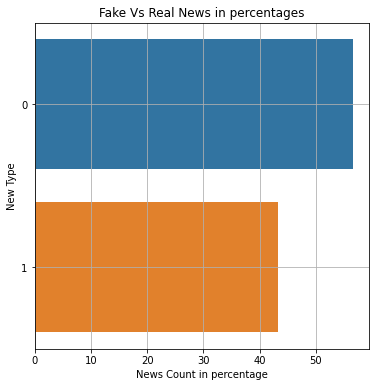

In [14]:
c = df.label.value_counts()*100/df.shape[0]
plt.figure(figsize = (6,6))
plt.title("Fake Vs Real News in percentages")
sns.barplot(x =c, y =c.index, orient = 'h')
plt.xlabel('News Count in percentage')
plt.ylabel('New Type')
plt.grid()
plt.show()

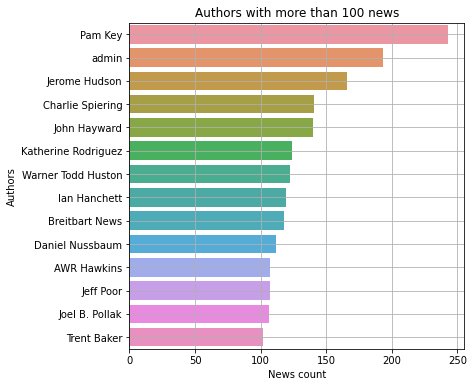

In [15]:
c = df['author'].value_counts()[df.author.value_counts()> 100]
#authors with more than 100 news
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.title("Authors with more than 100 news")
sns.barplot(x =c, y =c.index, orient = 'h')
plt.xlabel('News count')
plt.ylabel('Authors')
plt.grid()
plt.show()

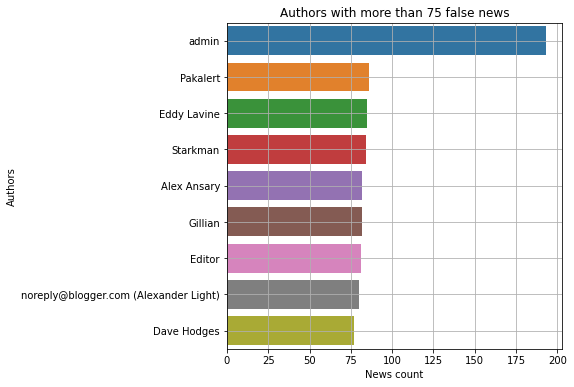

In [26]:
c = df[df['label'] ==1]['author'].value_counts()[df[df['label'] ==1]['author'].value_counts() >75]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.title("Authors with more than 75 false news")
sns.barplot(x =c, y =c.index, orient = 'h')
plt.xlabel('News count')
plt.ylabel('Authors')
plt.grid()
plt.show()

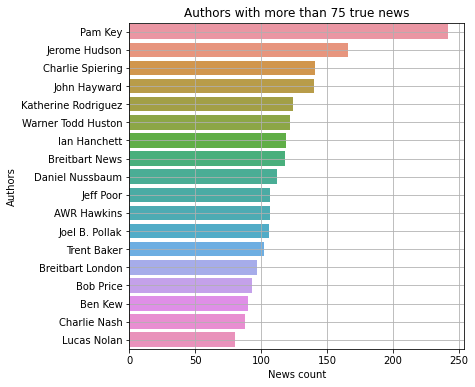

In [27]:
c = df[df['label'] ==0]['author'].value_counts()[df[df['label'] ==0]['author'].value_counts() >75]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.title("Authors with more than 75 true news")
sns.barplot(x =c, y =c.index, orient = 'h')
plt.xlabel('News count')
plt.ylabel('Authors')
plt.grid()
plt.show()

In [28]:
X = df.drop('label', axis =1)
y = df['label']

In [29]:
for i in [X,y]:
  print(i.shape)

(18285, 4)
(18285,)


In [30]:
# Performing Word embedding for the titles

In [31]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [36]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [37]:
import re

In [38]:
data = X.copy()

In [39]:
# Preprocessing the data 
from nltk.stem import WordNetLemmatizer
ps = WordNetLemmatizer()
corpus = []
for i in data['title']:
  c = re.sub('[^a-z,A-Z]',' ',i).lower().split()
  rev = [ps.lemmatize(j, 'v') for j in c if j not in stopwords.words('english')]
  corpus.append(' '.join(rev))


In [40]:
corpus[0]

'house dem aide even see comey letter jason chaffetz tweet'

In [41]:
data['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [42]:
# One hot representation
vocab_size =  10000
one_hot_represention = [one_hot(i, vocab_size) for i in corpus]

In [43]:
# ARRIVING AT THE MAX PADDING NUMBER TO GAIN THE MAXIMUM NUMBER OF LEN FOR ALL THE SENTENCES
max_padding = pd.Series([len(i) for i in one_hot_represention]).max()+2

In [44]:
# Pad sequences
Padding_embedded_corpus = pad_sequences(one_hot_represention, padding= 'pre', maxlen= max_padding)

In [45]:
Padding_embedded_corpus

array([[   0,    0,    0, ...,  943,  733, 8590],
       [   0,    0,    0, ..., 6844, 5167, 7850],
       [   0,    0,    0, ..., 9642, 5943, 6208],
       ...,
       [   0,    0,    0, ..., 4069, 9548, 9030],
       [   0,    0,    0, ..., 9102, 2580, 4890],
       [   0,    0,    0, ...,  794, 2590, 8914]], dtype=int32)

In [46]:
# Creating the word embedding represation or Feature Representation and building the LSTM brained RNN
dims = 40
model = Sequential()
model.add(Embedding(vocab_size, input_length= max_padding , output_dim= dims))
model.add(LSTM(100, activation= 'elu', recurrent_activation= 'sigmoid'))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 40)            400000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
import numpy as np
X = np.array(Padding_embedded_corpus)
y = np.array(y)

In [48]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [49]:
for i in [X_train, y_train, X_test, y_test]:
  print(i.shape)

(13713, 49)
(13713,)
(4572, 49)
(4572,)


In [50]:
# Model training
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 50, batch_size= 64)

Epoch 1/50
215/215 [==============================] - 22s 88ms/step - loss: 0.4756 - accuracy: 0.7359 - val_loss: 0.1824 - val_accuracy: 0.9237
Epoch 2/50
215/215 [==============================] - 19s 88ms/step - loss: 0.1324 - accuracy: 0.9506 - val_loss: 0.1748 - val_accuracy: 0.9272
Epoch 3/50
215/215 [==============================] - 19s 86ms/step - loss: 0.0702 - accuracy: 0.9756 - val_loss: 0.1892 - val_accuracy: 0.9283
Epoch 4/50
215/215 [==============================] - 19s 88ms/step - loss: 0.0391 - accuracy: 0.9866 - val_loss: 0.2398 - val_accuracy: 0.9298
Epoch 5/50
215/215 [==============================] - 20s 91ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.2933 - val_accuracy: 0.9287
Epoch 6/50
215/215 [==============================] - 20s 91ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.4329 - val_accuracy: 0.9250
Epoch 7/50
215/215 [==============================] - 20s 92ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.2977 - val_accuracy:

In [51]:
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [52]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [53]:
confusion_matrix(y_test, y_pred)

array([[2352,  201],
       [ 172, 1847]])

In [54]:
accuracy_score(y_test, y_pred)

0.918416447944007

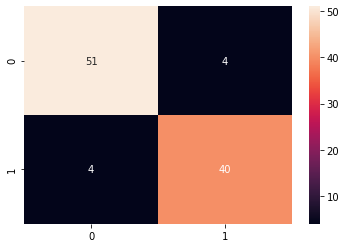

In [55]:
cm = (confusion_matrix(y_pred, y_test)*100/X_test.shape[0]).round(0)
sns.heatmap(cm, annot = True)
plt.show()